# EDA and preprocessing data

###  Importing libraries and exploring data

In [1]:
from IPython.core.interactiveshell import InteractiveShell
import heapq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from IPython.core.display import HTML
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

class MismatchLengthException(Exception):
    """ to print error messages and stop the program when needed """
    pass

'''Set up pretty printing of variables on all lines'''
InteractiveShell.ast_node_interactivity = "all"


def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    Credits to epmoyer
    link https://github.com/epmoyer/ipy_table/issues/24
    '''
    return HTML(
        '<table><tr style="background-color:white;">' +
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

Inspecting the head of our dataset and getting a general statistical description of the whole data

In [2]:
iris_df = pd.read_csv('../data/iris.csv', header=None, names=[
                      "sepal length[cm]", "sepal width[cm]", "petal length[cm]", "petal width", "label"])
multi_table([iris_df.head(), iris_df.describe()])

In [3]:
iris_df.dtypes, iris_df.shape, iris_df.label.nunique()

(sepal length[cm]    float64
 sepal width[cm]     float64
 petal length[cm]    float64
 petal width         float64
 label                object
 dtype: object, (150, 5), 3)

###  Preprocessing Data

Converting the categorical `label` column in data to numerical values.

In [4]:
iris_df['label'] = iris_df.label.map({'Iris-setosa': 0,
                                      'Iris-versicolor': 1,
                                      'Iris-virginica': 2})
iris_df.head()

,sepal length[cm],sepal width[cm],petal length[cm],petal width,label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


### Split the data into training and testing sets with sklearn.preprocessing.train_test_split

In [5]:
names = ["sepal length[cm]", "petal width"]  # Only using two features for now

df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(
    iris_df[names], iris_df['label'], random_state=0)

X_train = df_X_train.to_numpy()
X_test = df_X_test.to_numpy()
y_train = df_y_train.to_numpy()
y_test = df_y_test.to_numpy()

# Looking at the train/test split
print("The number of training examples: ", X_train.shape[0])
print("The number of test exampels: ", X_test.shape[0])

print("The first four training labels")
print(y_train[0:4])

print("The first four iris' measurements")
print(X_test[0:4])

The number of training examples:  112
The number of test exampels:  38
The first four training labels
[1 1 2 0]
The first four iris' measurements
[[5.8 2.4]
 [6.  1. ]
 [5.5 0.2]
 [7.3 1.8]]


### visualizing the data set

Using a scatter plot to visualize the dataset

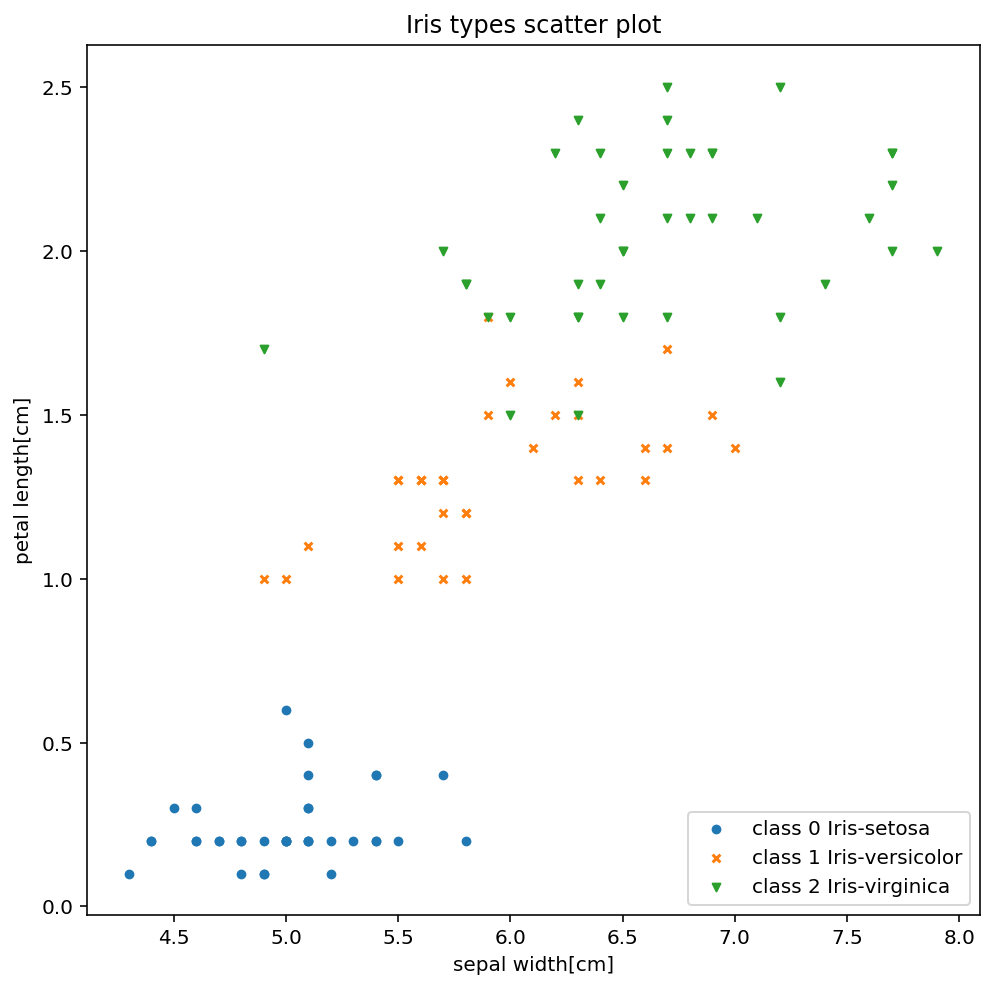

In [6]:
iris_names = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

for i in range(3):
    ax.scatter(X_train[y_train == i, 0],
               X_train[y_train == i, 1],
               marker=('o', 'x', 'v')[i],
               s=15,
               label='class ' + str(i) + ' ' + iris_names[i])

ax.set_title("Iris types scatter plot")
ax.set_xlabel('sepal width[cm]')
ax.set_ylabel('petal length[cm]')
ax.legend(loc='lower right')

plt.show(fig);

# K Nearest Neighbors Supervised Learning Algorithm

### Definining the Distance Metric Class

In [7]:
class DistanceMetric:

    @staticmethod
    def minkowski_distance(x1, x2, p):
        """ 
        x1 and x2 must be numpy.ndarrays
        p is the distance order i.e. p=1 (Manhattan), p=2 (Euclidean)
        Returns a np.array of distances
        """
        return np.power(np.sum((np.absolute(x1-x2))**p, axis=1), 1/p)

    @staticmethod
    def manhattan_distance(x1, x2):
        return DistanceMetric.minkowski_distance(x1, x2, p=1)

    @staticmethod
    def euclidean_distance(x1, x2):
        return DistanceMetric.minkowski_distance(x1, x2, p=2)

### Defining the KNN and EvaluationMetric classes

In [9]:
class KNN:

    __slots__ = ['k', 'X_train', 'y_train', 'distance_metric']

    def __init__(self, k=5, distance=DistanceMetric.euclidean_distance):
        """
        Note storing X_train and y_train in memory might be very expensive
        """
        self.k = k
        self.X_train = None
        self.y_train = None
        self.y_pred = None
        self.distance_metric = distance

    @staticmethod
    def get_neighbors_kd_tree(X_train, y_train, X_test, k, distance=DistanceMetric.euclidean_distance):
        raise NotImplementedError(
            "kd tree KNN implementation not complete yet")

    @staticmethod
    def get_neighbors_brute_force(X_train, y_train, X_test, k, distance=DistanceMetric.euclidean_distance):
        """
        Returns a 2D array of indexes of k nearest neighbors for each element in X_test
        """
        # Faster Alternative: sklearn.metrics.pairwise_distances(X_train, X_test)
        dist_arr = [KNN.get_knn_idx(
            X_train, test, k, distance) for test in X_test]
        return dist_arr

    @staticmethod
    def get_knn_idx(X_train, single_test, k, distance=DistanceMetric.euclidean_distance):
        """
        Returns indexes of k nearest neighbors for the single element test
        """
        dist_arr_with_idx = [[dist, i]
                             for i, dist in enumerate(distance(X_train, single_test))]
        heapq.heapify(dist_arr_with_idx)
        return [idx for val, idx in heapq.nsmallest(k, dist_arr_with_idx)]

    @staticmethod
    def get_label(neighbors_list):
        """ 
        neighbors_list must be list of labels i.e. [1,0,0,1,1]
        Return label with the majority votes 
        """
        label_counter = Counter(neighbors_list)
        max_repeat = max(label_counter.values())
        return [key for key, value in label_counter.items() if value == max_repeat][0]

    @staticmethod
    def predict_labels(X_train, y_train, X_test, k,
                       distance=DistanceMetric.euclidean_distance,
                       knn_algorithm=None):
        knn_algorithm = KNN.get_neighbors_brute_force if knn_algorithm is None else knn_algorithm
        knn_idx_2d_arr = knn_algorithm(X_train, y_train, X_test, k, distance)
        return np.array([KNN.get_label(np.take(y_train, knn_idx_arr)) for knn_idx_arr in knn_idx_2d_arr])

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        self.y_pred = KNN.predict_labels(self.X_train,
                                         self.y_train,
                                         X_test,
                                         self.k,
                                         distance=self.distance_metric,
                                         knn_algorithm=KNN.get_neighbors_brute_force)
        return self.y_pred


class EvaluationMetric:

    def __init__(self, X_train, X_test, y_train, y_test, k, distance=DistanceMetric.euclidean_distance):
        self.y_test = y_test
        self.y_pred = KNN.predict_labels(X_train, y_train, X_test, k,
                                         distance=DistanceMetric.euclidean_distance,
                                         knn_algorithm=KNN.get_neighbors_brute_force)
        if len(self.y_test) != len(self.y_pred):
            raise MismatchLengthException(
                "y_test and y_pred length do not match")

    @staticmethod
    def accuracy(y_test, y_pred):
        """ (TP+FP) / (TP+TN+FP+FN)"""
        if len(y_test) != len(y_pred):
            raise MismatchLengthException(
                "y_test and y_pred length do not match")
        return len([1 for actual, pred in zip(y_test, y_pred) if actual == pred]) / len(y_test)

    def get_accuracy(self):
        return EvaluationMetric.accuracy(self.y_test, self.y_pred)

    @staticmethod
    def confusion_matrix(y_test, y_pred):
        """      Actual
        Pred  | TP | FP |
              | FN | TN |
        """
        conf_matrix = [[0]*len(set(y_test)) for i in range(len(set(y_test)))]
        for actual, pred in zip(y_test, y_pred):
            conf_matrix[pred][actual] += 1
        print(np.matrix(conf_matrix))

    @staticmethod
    def evaluate(y_test, y_pred):
        if len(y_test) != len(y_pred):
            raise MismatchLengthException(
                "y_test and y_pred length do not match")

        print(
            f"The Accuracy of the KNN model is {EvaluationMetric.accuracy(y_test, y_pred)}")
        print("Confusion Matrix")
        EvaluationMetric.confusion_matrix(y_test, y_pred)

### Running our KNN algorithm with different values of k and different distance metrics

#### Euclidean metric

In [10]:
for k in range(1, 12, 2):
    prediction = KNN.predict_labels(X_train,
                                    y_train,
                                    X_test,
                                    k=k,
                                    distance=DistanceMetric.euclidean_distance,
                                    knn_algorithm=KNN.get_neighbors_brute_force)

    print(f"With distance=euclidean and k = {k}, accuracy = {EvaluationMetric.accuracy(y_test, prediction)}")
    EvaluationMetric.confusion_matrix(y_test, prediction)

With distance=euclidean and k = 1, accuracy = 0.9210526315789473
[[13  0  0]
 [ 0 14  1]
 [ 0  2  8]]
With distance=euclidean and k = 3, accuracy = 0.9736842105263158
[[13  0  0]
 [ 0 16  1]
 [ 0  0  8]]
With distance=euclidean and k = 5, accuracy = 0.9473684210526315
[[13  0  0]
 [ 0 15  1]
 [ 0  1  8]]
With distance=euclidean and k = 7, accuracy = 0.9736842105263158
[[13  0  0]
 [ 0 16  1]
 [ 0  0  8]]
With distance=euclidean and k = 9, accuracy = 0.9736842105263158
[[13  0  0]
 [ 0 16  1]
 [ 0  0  8]]
With distance=euclidean and k = 11, accuracy = 0.9736842105263158
[[13  0  0]
 [ 0 16  1]
 [ 0  0  8]]


#### Manhattan Metric

In [11]:
for k in range(1, 12, 2):
    prediction = KNN.predict_labels(X_train,
                                    y_train,
                                    X_test,
                                    k=k,
                                    distance=DistanceMetric.manhattan_distance,
                                    knn_algorithm=KNN.get_neighbors_brute_force)

    print(f"With distance=manhattan and k = {k}, accuracy = {EvaluationMetric.accuracy(y_test, prediction)}")
    EvaluationMetric.confusion_matrix(y_test, prediction)

With distance=manhattan and k = 1, accuracy = 0.9210526315789473
[[13  0  0]
 [ 0 14  1]
 [ 0  2  8]]
With distance=manhattan and k = 3, accuracy = 0.9736842105263158
[[13  0  0]
 [ 0 16  1]
 [ 0  0  8]]
With distance=manhattan and k = 5, accuracy = 0.9473684210526315
[[13  0  0]
 [ 0 15  1]
 [ 0  1  8]]
With distance=manhattan and k = 7, accuracy = 0.9736842105263158
[[13  0  0]
 [ 0 16  1]
 [ 0  0  8]]
With distance=manhattan and k = 9, accuracy = 0.9736842105263158
[[13  0  0]
 [ 0 16  1]
 [ 0  0  8]]
With distance=manhattan and k = 11, accuracy = 0.9473684210526315
[[13  0  0]
 [ 0 16  2]
 [ 0  0  7]]


### Using all four features in the Iris dataset

In [12]:
df_X_train4, df_X_test4, df_y_train4, df_y_test4 = train_test_split(
    iris_df, iris_df['label'], random_state=0)

X_train4 = df_X_train4.to_numpy()
X_test4 = df_X_test4.to_numpy()
y_train4 = df_y_train4.to_numpy()
y_test4 = df_y_test4.to_numpy()

#### Euclidean metric

In [13]:
for k in range(1, 12, 2):
    prediction = KNN.predict_labels(X_train4,
                                    y_train4,
                                    X_test4,
                                    k=k,
                                    distance=DistanceMetric.euclidean_distance,
                                    knn_algorithm=KNN.get_neighbors_brute_force)

    print(f"With distance=euclidean and k = {k}, accuracy = {EvaluationMetric.accuracy(y_test4, prediction)}")
    EvaluationMetric.confusion_matrix(y_test, prediction)

With distance=euclidean and k = 1, accuracy = 1.0
[[13  0  0]
 [ 0 16  0]
 [ 0  0  9]]
With distance=euclidean and k = 3, accuracy = 1.0
[[13  0  0]
 [ 0 16  0]
 [ 0  0  9]]
With distance=euclidean and k = 5, accuracy = 1.0
[[13  0  0]
 [ 0 16  0]
 [ 0  0  9]]
With distance=euclidean and k = 7, accuracy = 1.0
[[13  0  0]
 [ 0 16  0]
 [ 0  0  9]]
With distance=euclidean and k = 9, accuracy = 1.0
[[13  0  0]
 [ 0 16  0]
 [ 0  0  9]]
With distance=euclidean and k = 11, accuracy = 1.0
[[13  0  0]
 [ 0 16  0]
 [ 0  0  9]]


#### Manhattan Metric

In [14]:
for k in range(1, 12, 2):
    prediction = KNN.predict_labels(X_train4,
                                    y_train4,
                                    X_test4,
                                    k=k,
                                    distance=DistanceMetric.manhattan_distance,
                                    knn_algorithm=KNN.get_neighbors_brute_force)

    print(f"With distance=manhattan and k = {k}, accuracy = {EvaluationMetric.accuracy(y_test4, prediction)}")
    EvaluationMetric.confusion_matrix(y_test, prediction)

With distance=manhattan and k = 1, accuracy = 1.0
[[13  0  0]
 [ 0 16  0]
 [ 0  0  9]]
With distance=manhattan and k = 3, accuracy = 1.0
[[13  0  0]
 [ 0 16  0]
 [ 0  0  9]]
With distance=manhattan and k = 5, accuracy = 1.0
[[13  0  0]
 [ 0 16  0]
 [ 0  0  9]]
With distance=manhattan and k = 7, accuracy = 1.0
[[13  0  0]
 [ 0 16  0]
 [ 0  0  9]]
With distance=manhattan and k = 9, accuracy = 1.0
[[13  0  0]
 [ 0 16  0]
 [ 0  0  9]]
With distance=manhattan and k = 11, accuracy = 1.0
[[13  0  0]
 [ 0 16  0]
 [ 0  0  9]]


Our accuracy goes up to 100% once we start using all four features in the original dataset